In [10]:
#1
import pandas as pd

In [12]:

# Load the dataset
try:
    file_path = "CSVFILE.csv"
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Display basic information
print("\nFirst few rows of the dataset:")
print(df.head())  # Show first few rows

print("\nDataset information:")
print(df.info())  # Data types and missing values

print("\nSummary statistics:")
print(df.describe(include='all'))  # Summary statistics for all columns

# Handle missing values (if any)
if df.isnull().sum().any():
    print("\nMissing values found. Handling missing values...")
    df = df.dropna()  # Drop rows with missing values
    print("Missing values handled.")
else:
    print("\nNo missing values found.")

# Keep the 'Gender' column untouched (no dummy encoding)
print("\n'Gender' column will remain as is.")

# Save preprocessed data
try:
    output_path = "preprocessed_data.csv"
    df.to_csv(output_path, index=False)
    print(f"\nPreprocessed data saved successfully at: {output_path}")
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

Dataset loaded successfully!

First few rows of the dataset:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

                                        Reviews  
0    Dissatisfied with the shopping experience.  
1  Great shopping experience, highly satisfied!  
2    Dissatisfied with the shopping experience.  
3  Great shopping experience, highly satisfied!  
4        Average experience, could be improved.  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------     

In [14]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Reviews
0,1,Male,19,15,39,Dissatisfied with the shopping experience.
1,2,Male,21,15,81,"Great shopping experience, highly satisfied!"
2,3,Female,20,16,6,Dissatisfied with the shopping experience.
3,4,Female,23,16,77,"Great shopping experience, highly satisfied!"
4,5,Female,31,17,40,"Average experience, could be improved."


In [16]:
#2
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions
import time
from tqdm import tqdm  # Install with: pip install tqdm


In [ ]:

# Watson NLU setup
try:
    authenticator = IAMAuthenticator('your_api_key') #replace with your APIKEY
    nlu = NaturalLanguageUnderstandingV1(
        version='2022-04-07',
        authenticator=authenticator
    )
    nlu.set_service_url('your_service_url') #replace with your APIURL
    print("Watson NLU initialized successfully!")
except Exception as e:
    print(f"Error initializing Watson NLU: {e}")
    exit()

# Function to analyze sentiment with retries and delays
def analyze_sentiment(text, retries=3, delay=1):
    if not text or len(str(text).strip().split()) < 3:
        return 0
    
    for attempt in range(retries):
        try:
            response = nlu.analyze(
                text=text,
                features=Features(sentiment=SentimentOptions()))
            return response.result['sentiment']['document']['score']
        except Exception as e:
            if attempt < retries - 1:
                time.sleep(delay * (attempt + 1))  # Exponential backoff
                continue
            print(f"Failed to analyze: {text[:50]}... | Error: {str(e)[:100]}")
            return 0
    return 0

# Process reviews with progress tracking
print("\nStarting sentiment analysis...")
tqdm.pandas(desc="Processing Reviews")
df['Watson_Sentiment'] = df['Reviews'].progress_apply(analyze_sentiment)

# Categorize sentiment
df['Sentiment_Category'] = df['Watson_Sentiment'].apply(
    lambda x: 'Positive' if x > 0.2 else 'Negative' if x < -0.2 else 'Neutral'
)

# Save intermediate results
try:
    df.to_csv("partial_results.csv", index=False)
    print("\nProgress saved to partial_results.csv")
except Exception as e:
    print(f"Error saving partial results: {e}")

Watson NLU initialized successfully!

Starting sentiment analysis...


Processing Reviews: 100%|████████████████████████████████████████████████████████████| 200/200 [02:30<00:00,  1.33it/s]


Progress saved to partial_results.csv


In [20]:
#3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Dataset with sentiment analysis loaded successfully!

Columns in the dataset: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Reviews', 'Watson_Sentiment', 'Sentiment_Category']


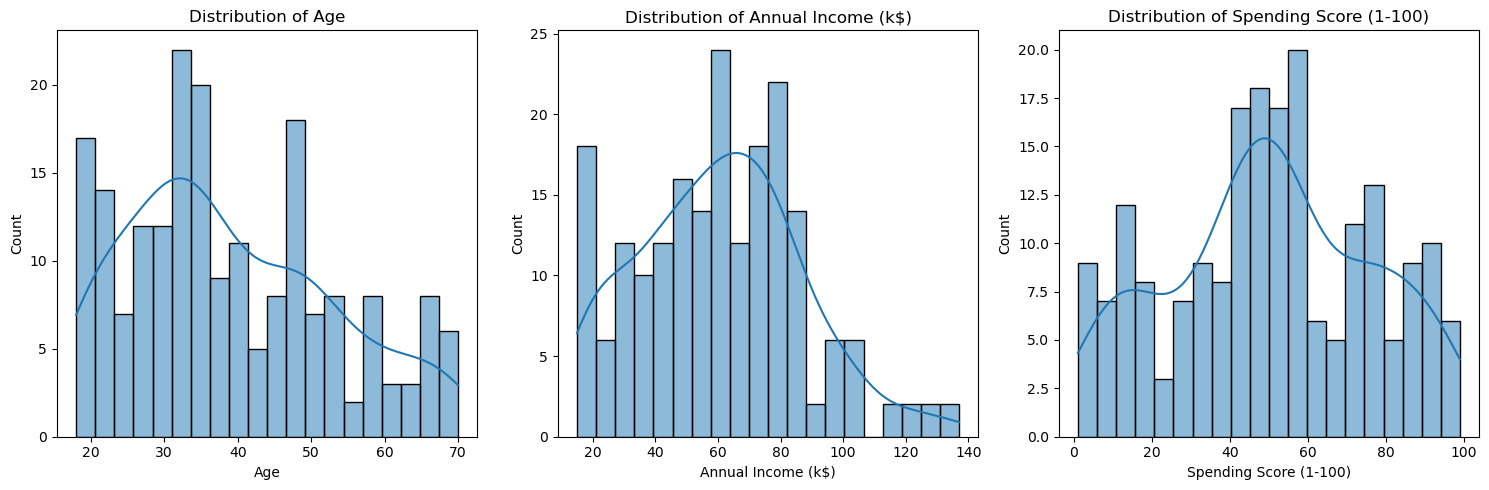

C:\Users\aksha\AppData\Local\Temp\ipykernel_17900\538030441.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Category', data=df, palette='viridis')


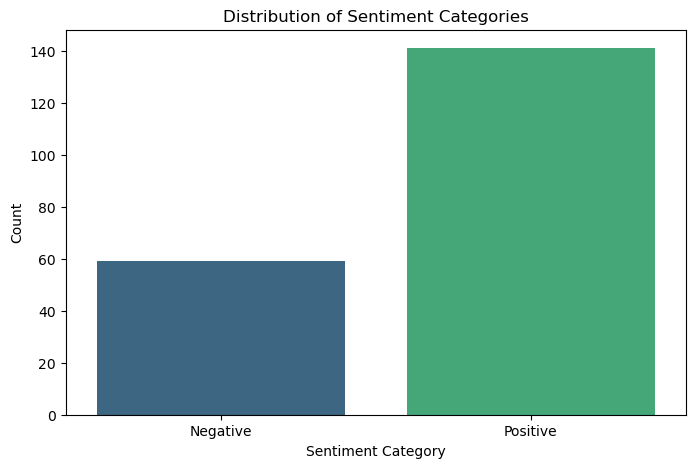

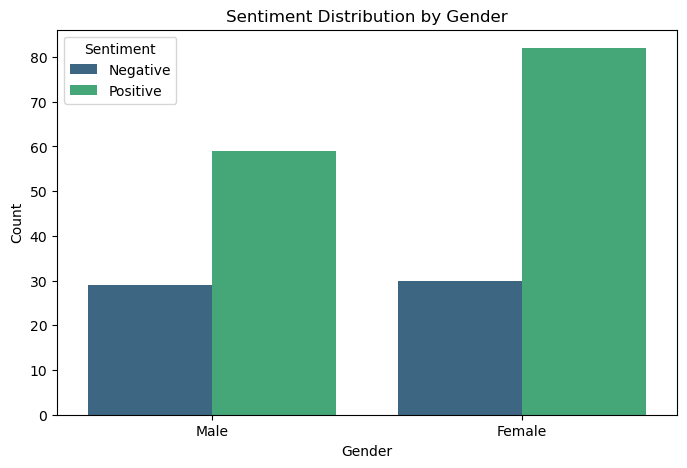

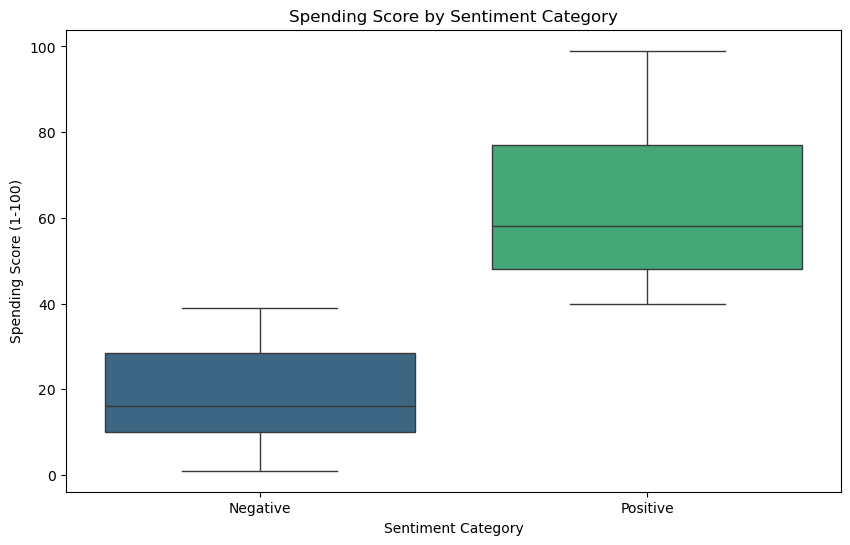

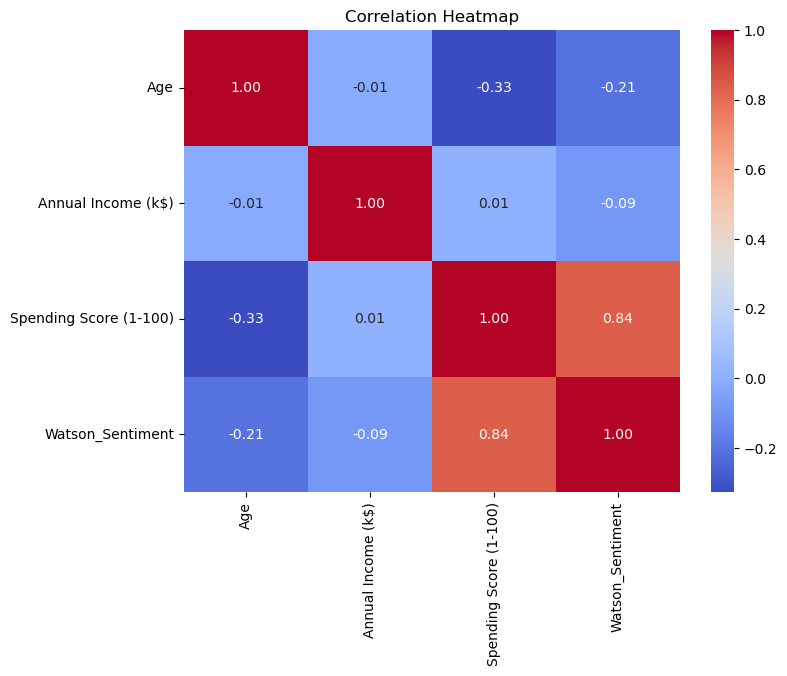

In [21]:

# Load the dataset with sentiment analysis results
try:
    df = pd.read_csv("partial_results.csv")
    print("Dataset with sentiment analysis loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Check columns
print("\nColumns in the dataset:", df.columns.tolist())

# 1. Distribution of Numerical Variables
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2. Distribution of Sentiment Categories
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Category', data=df, palette='viridis')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# 3. Sentiment by Gender
if 'Gender' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Gender', hue='Sentiment_Category', data=df, palette='viridis')
    plt.title('Sentiment Distribution by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.show()
else:
    print("Warning: 'Gender' column not found. Skipping sentiment by gender plot.")

# 4. Spending Score by Sentiment Category (Fixed Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Sentiment_Category', 
    y='Spending Score (1-100)', 
    data=df, 
    hue='Sentiment_Category',  # Map hue to the same variable as x
    palette='viridis', 
    legend=False               # Suppress redundant legend
)
plt.title('Spending Score by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Spending Score (1-100)')
plt.show()

# 5. Correlation Heatmap (Numerical Variables + Sentiment)
corr_df = df[numerical_cols + ['Watson_Sentiment']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [24]:
#4
from sklearn.cluster import KMeans
import numpy as np
import os
import warnings


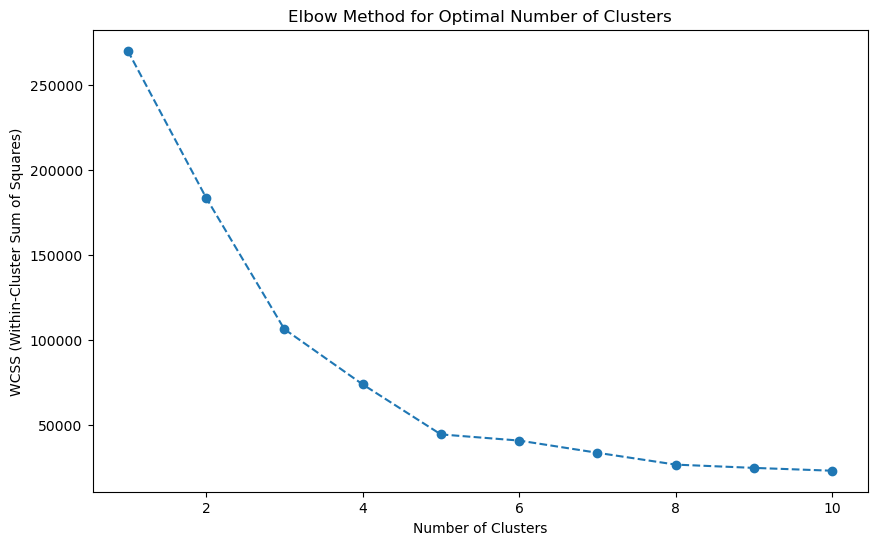

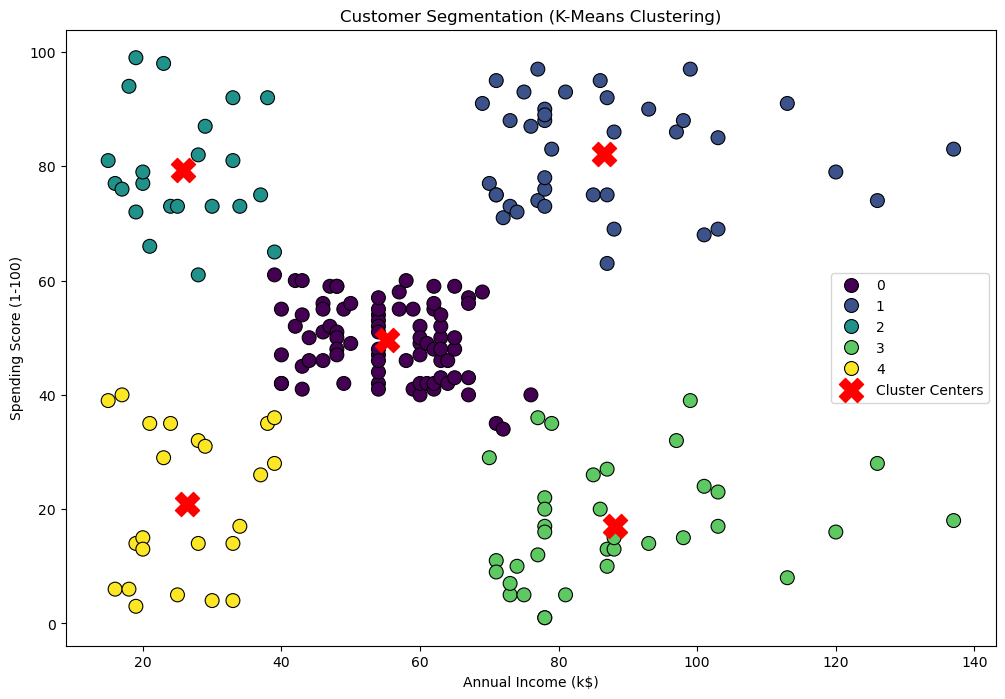

In [25]:

# Suppress all warnings
warnings.filterwarnings('ignore')

# Set environment variable to avoid memory leak
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

# Select features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    # Using 'auto' for n_init to align with future versions
    kmeans = KMeans(
        n_clusters=i, 
        init='k-means++', 
        random_state=42, 
        n_init='auto',
        max_iter=300
    )
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Apply K-Means with the optimal number of clusters (e.g., 5)
kmeans = KMeans(
    n_clusters=5, 
    init='k-means++', 
    random_state=42, 
    n_init='auto',
    max_iter=300
)
df['Cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    hue='Cluster', 
    data=df, 
    palette='viridis',
    s=100,
    edgecolor='black'
)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=300,
    c='red',
    marker='X',
    label='Cluster Centers'
)
plt.title('Customer Segmentation (K-Means Clustering)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# Save clustered data
df.to_csv("clustered_data.csv", index=False)

In [28]:
#5
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [30]:

# Features and target variable
X = df[['Age', 'Annual Income (k$)', 'Watson_Sentiment']]
y = df['Spending Score (1-100)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))

Mean Squared Error: 82.17
R^2 Score: 0.83

Feature Importances:
Watson_Sentiment      0.884038
Annual Income (k$)    0.067474
Age                   0.048489
dtype: float64


Mean Squared Error (MSE): 82.17
Root Mean Squared Error (RMSE): 9.06
R^2 Score: 0.83

Feature Importances:
Watson_Sentiment      0.884038
Annual Income (k$)    0.067474
Age                   0.048489
dtype: float64


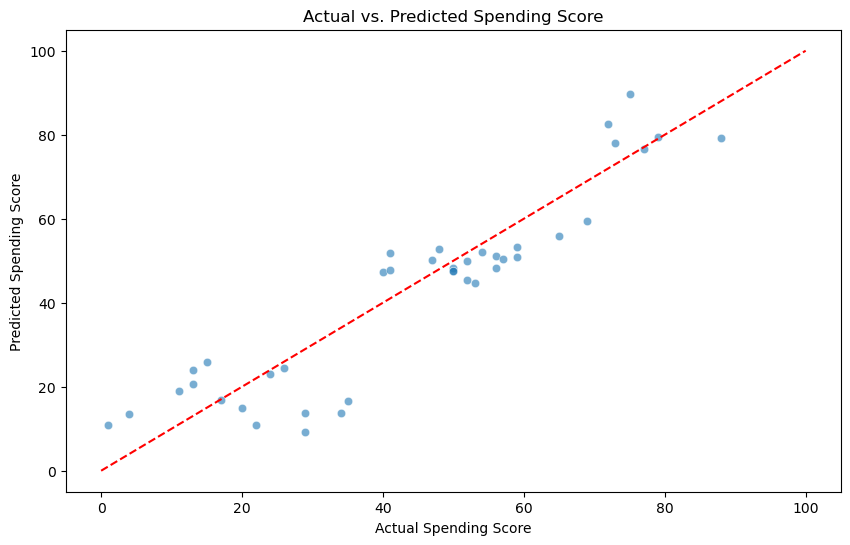

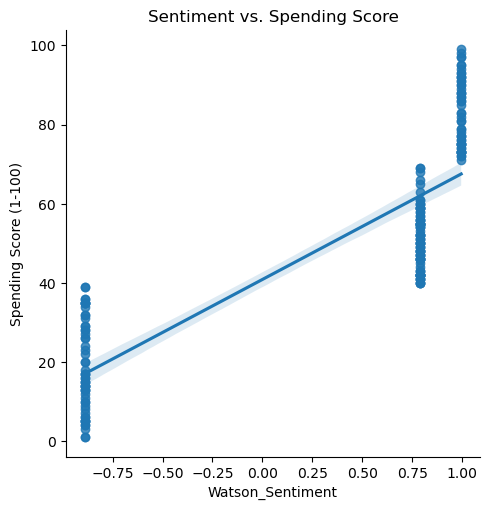

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the dataset
df = pd.read_csv("partial_results.csv")

# Features and target variable
X = df[['Age', 'Annual Income (k$)', 'Watson_Sentiment']]
y = df['Spending Score (1-100)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))

# Visualize predicted vs. actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
plt.xlabel('Actual Spending Score')
plt.ylabel('Predicted Spending Score')
plt.title('Actual vs. Predicted Spending Score')
plt.show()

# Validate Sentiment-Spending Relationship
sns.lmplot(x='Watson_Sentiment', y='Spending Score (1-100)', data=df)
plt.title('Sentiment vs. Spending Score')
plt.show()

Cluster Profiles:
    Cluster        Age  Annual Income (k$)  Spending Score (1-100)  \
0        0  42.716049           55.296296               49.518519   
1        1  32.692308           86.538462               82.128205   
2        2  25.272727           25.727273               79.363636   
3        3  41.114286           88.200000               17.114286   
4        4  45.217391           26.304348               20.913043   

  Sentiment_Category  
0           Positive  
1           Positive  
2           Positive  
3           Negative  
4           Negative  


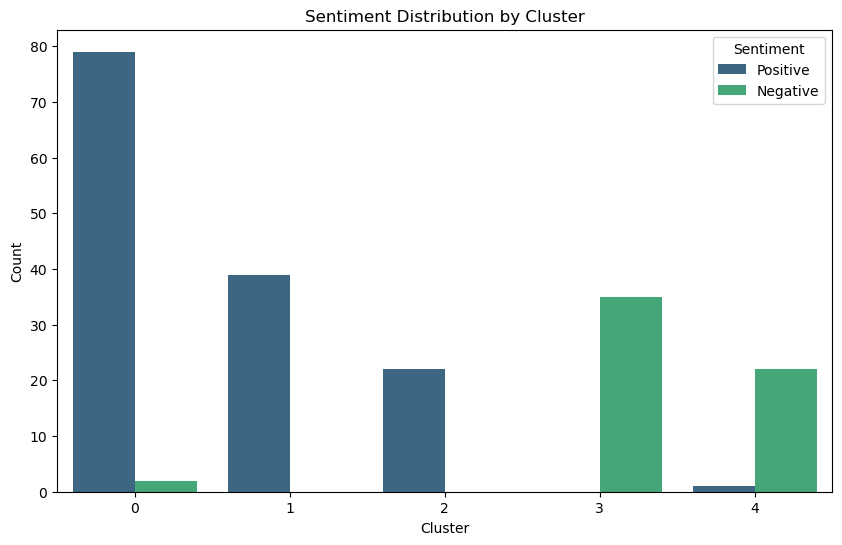

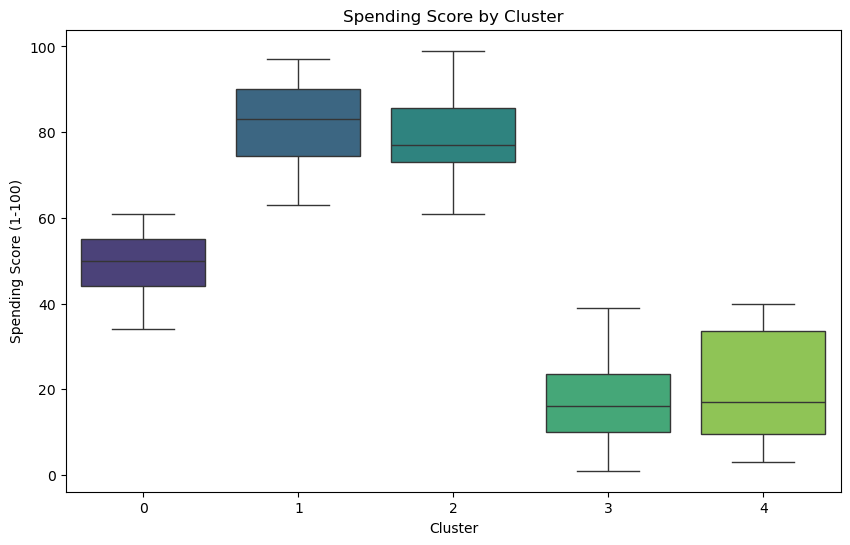


Recommendations:

Cluster 0:
- Average Age: 42.7 years
- Average Annual Income: $55.3k
- Average Spending Score: 49.5
- Most Common Sentiment: Positive
  Action: Reward loyal customers with exclusive offers or loyalty programs.
  Action: Encourage higher spending with discounts or bundled offers.

Cluster 1:
- Average Age: 32.7 years
- Average Annual Income: $86.5k
- Average Spending Score: 82.1
- Most Common Sentiment: Positive
  Action: Reward loyal customers with exclusive offers or loyalty programs.
  Action: Upsell premium products or services to high-spending customers.

Cluster 2:
- Average Age: 25.3 years
- Average Annual Income: $25.7k
- Average Spending Score: 79.4
- Most Common Sentiment: Positive
  Action: Reward loyal customers with exclusive offers or loyalty programs.
  Action: Upsell premium products or services to high-spending customers.

Cluster 3:
- Average Age: 41.1 years
- Average Annual Income: $88.2k
- Average Spending Score: 17.1
- Most Common Sentiment: Negat

In [34]:
# Load clustered data
df = pd.read_csv("clustered_data.csv")

# Cluster insights
cluster_stats = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean',
    'Sentiment_Category': lambda x: x.mode()[0]  # Most common sentiment in each cluster
}).reset_index()

print("Cluster Profiles:\n", cluster_stats)

# Sentiment distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Sentiment_Category', data=df, palette='viridis')
plt.title('Sentiment Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Spending Score by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=df, palette='viridis')
plt.title('Spending Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Spending Score (1-100)')
plt.show()

# Recommendations based on insights
print("\nRecommendations:")
for cluster in cluster_stats['Cluster'].unique():
    age = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'Age'].values[0]
    income = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'Annual Income (k$)'].values[0]
    spending = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'Spending Score (1-100)'].values[0]
    sentiment = cluster_stats.loc[cluster_stats['Cluster'] == cluster, 'Sentiment_Category'].values[0]
    
    print(f"\nCluster {cluster}:")
    print(f"- Average Age: {age:.1f} years")
    print(f"- Average Annual Income: ${income:.1f}k")
    print(f"- Average Spending Score: {spending:.1f}")
    print(f"- Most Common Sentiment: {sentiment}")
    
    if sentiment == 'Positive':
        print("  Action: Reward loyal customers with exclusive offers or loyalty programs.")
    elif sentiment == 'Negative':
        print("  Action: Address pain points through personalized support and targeted promotions.")
    else:
        print("  Action: Engage with neutral customers through surveys to understand their needs.")
    
    if spending < 50:
        print("  Action: Encourage higher spending with discounts or bundled offers.")
    elif spending > 70:
        print("  Action: Upsell premium products or services to high-spending customers.")

In [36]:
import joblib

# Save the model
joblib.dump(model, "spending_score_predictor.pkl")

['spending_score_predictor.pkl']